# **Classification with GCN**

In [1]:
!pip install -q torch-geometric
# !pip install -q torch-scatter torch-sparse -f https://data.pyg.org/whl/torch-{torch.__version__}.html

In [2]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

from torch_geometric.nn import GCNConv
from torch_geometric.datasets import Planetoid
from torch_geometric.utils import degree

In [8]:
torch.manual_seed(1)
torch.cuda.manual_seed(1)
torch.cuda.manual_seed_all(1)
torch.backends.cudnn.deterministic=True
torch.backends.cudnn.benchmark =True
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


# **Loading the CORA Dataset**

In [4]:
dataset = Planetoid(root=".", name="cora")
data = dataset[0]
print(data)

Processing...


Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])


Done!


In [5]:
print(f"Number of graphs   : {len(dataset)}")
print(f"Number of nodes    : {data.num_nodes}")
print(f"Number of features : {dataset.num_features}")
print(f"Number of classes  : {dataset.num_classes}")
print(f"Has isolated nodes : {data.has_isolated_nodes()}")
print(f"Has self-loops     : {data.has_self_loops()}")
print(f"Is undirected      : {data.is_undirected()}")

Number of graphs   : 1
Number of nodes    : 2708
Number of features : 1433
Number of classes  : 7
Has isolated nodes : False
Has self-loops     : False
Is undirected      : True


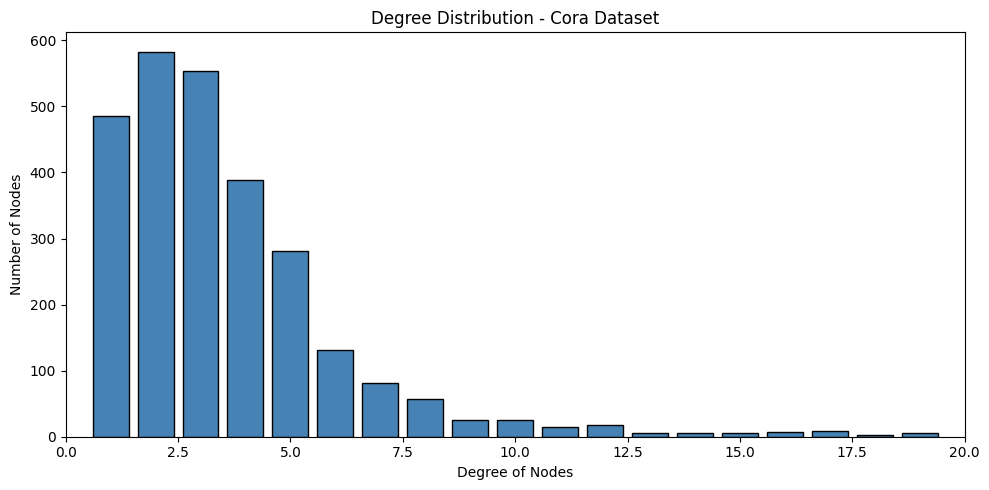

In [6]:
deg = degree(data.edge_index[0], num_nodes=data.num_nodes).numpy().astype(int)
unique_degs, counts = np.unique(deg, return_counts=True)

plt.figure(figsize=(10, 5))
plt.bar(unique_degs, counts, color='steelblue', edgecolor='black')
plt.xlabel('Degree of Nodes')
plt.ylabel('Number of Nodes')
plt.title('Degree Distribution - Cora Dataset')
plt.xlim(0, 20)
plt.tight_layout()
plt.show()

# **Defining GCN Model**

**GCN** → Graph Convolutional Networks

In [16]:
class GCN(torch.nn.Module):
  def __init__(self, in_channels, hidden_channels, out_channels):
    super().__init__()
    self.conv1 = GCNConv(in_channels, hidden_channels)
    self.conv2 = GCNConv(hidden_channels, out_channels)
  def forward(self, x, edge_index):
    x = self.conv1(x, edge_index)
    x = F.relu(x)
    x = F.dropout(x, p=0.5, training=self.training)
    x = self.conv2(x, edge_index)
    return x

In [17]:
model = GCN(dataset.num_features, 16, dataset.num_classes).to(device)
data = data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr= 0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()
print(model)

GCN(
  (conv1): GCNConv(1433, 16)
  (conv2): GCNConv(16, 7)
)


# **Train and Evaluate**

In [18]:
def train():
    model.train()
    optimizer.zero_grad()
    out  = model(data.x, data.edge_index)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

In [19]:
def test():
    model.eval()
    with torch.no_grad():
        out  = model(data.x, data.edge_index)
        pred = out.argmax(dim=1)
        train_acc = (pred[data.train_mask] == data.y[data.train_mask]).float().mean().item()
        test_acc  = (pred[data.test_mask]  == data.y[data.test_mask]).float().mean().item()
    return train_acc, test_acc

In [20]:
train_accs, test_accs = [], []

for epoch in range(1, 101):
    loss = train()
    train_acc, test_acc = test()
    train_accs.append(train_acc)
    test_accs.append(test_acc)
    if epoch % 10 == 0:
        print(f"Epoch {epoch:3d} | Loss: {loss:.4f} | Train Acc: {train_acc:.4f} | Test Acc: {test_acc:.4f}")

print(f"\nFinal Test Accuracy: {test_accs[-1]*100:.2f}%")

Epoch  10 | Loss: 0.9373 | Train Acc: 0.9643 | Test Acc: 0.7550
Epoch  20 | Loss: 0.2766 | Train Acc: 0.9929 | Test Acc: 0.7990
Epoch  30 | Loss: 0.1080 | Train Acc: 1.0000 | Test Acc: 0.8050
Epoch  40 | Loss: 0.0669 | Train Acc: 1.0000 | Test Acc: 0.8060
Epoch  50 | Loss: 0.0662 | Train Acc: 1.0000 | Test Acc: 0.8030
Epoch  60 | Loss: 0.0346 | Train Acc: 1.0000 | Test Acc: 0.7960
Epoch  70 | Loss: 0.0377 | Train Acc: 1.0000 | Test Acc: 0.8080
Epoch  80 | Loss: 0.0409 | Train Acc: 1.0000 | Test Acc: 0.7990
Epoch  90 | Loss: 0.0387 | Train Acc: 1.0000 | Test Acc: 0.8060
Epoch 100 | Loss: 0.0353 | Train Acc: 1.0000 | Test Acc: 0.7990

Final Test Accuracy: 79.90%


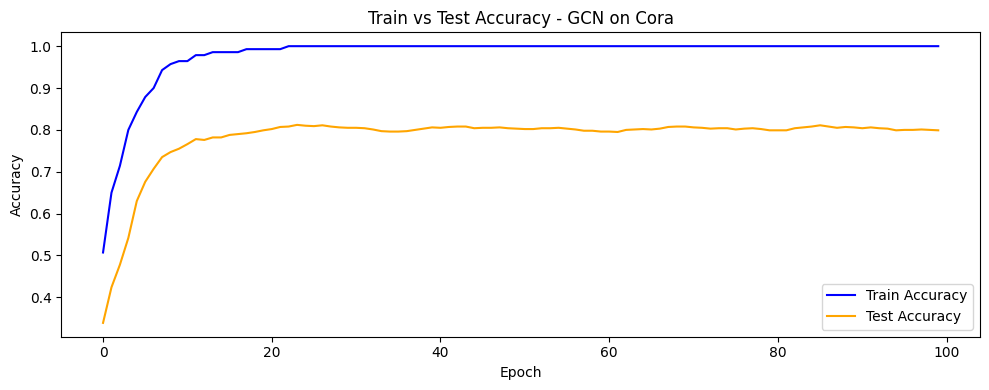

In [21]:
plt.figure(figsize=(10, 4))
plt.plot(train_accs, label='Train Accuracy', color='blue')
plt.plot(test_accs,  label='Test Accuracy',  color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train vs Test Accuracy - GCN on Cora')
plt.legend()
plt.tight_layout()
plt.show()